In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import yfinance as yf
from pandas_datareader import data as pdr
# import empyrical
# import pyfolio as pf

warnings.filterwarnings("ignore")
yf.pdr_override() 
plt.style.use("fivethirtyeight")

yesterday = datetime.now() - timedelta(1)
yesterday = datetime.strftime(yesterday, '%Y-%m-%d')
today = datetime.strftime(datetime.now(), '%Y-%m-%d')

In [14]:
## FUNCTIONS
def getData(ticker="SPY", start="1994-01-01", end=today, interval='1MO'):
    data = yf.download(tickers=ticker, interval=interval, start=start, end=end)
    data.dropna(axis=0, inplace=True)
    return data.reset_index()

def funcMomentum(data, momentum='simple'):
    data['shift1'] = data['Adj Close'].shift(1)
    data['shift3'] = data['Adj Close'].shift(3)
    data['shift6'] = data['Adj Close'].shift(6)
    data.drop(['Open','High','Low', 'Close', 'Volume'], axis=1, inplace=True)
    data.dropna(axis=0, inplace=True)
    composite = (12*(data['Adj Close']/data['shift1']-1)) + (4*(data['Adj Close']/data['shift3']-1)) + (2*(data['Adj Close']/data['shift6']-1))
    simple = ((data['Adj Close']/data['shift6']-1))
    if momentum == 'composite':
        data['momentum'] = composite
    else:
        data['momentum'] = simple
    return data

def acceleratingDualMomentum(interval='1MO', stocks=["spy","scz","tip"], momentum='simple'):
    ## Getting Data
    namespace = globals()
    for i in stocks:
        namespace['%s_data' % str(i)] = getData(ticker=i, end=today, interval=interval)

    ## Creating shift columns and calculating momentum
    for i in stocks:
        namespace['%s_data' % str(i)] = funcMomentum(namespace['%s_data' % str(i)], momentum)
        
    ## series lenght ## hardcoded because ETF release date won't change.
    date = scz_data['Date'] 
    spy_data2 = spy_data.copy()
    spy_data2 = spy_data2.iloc[-len(date):]
    tip_data2 = tip_data.copy()
    tip_data2 = tip_data.iloc[-len(date):]
    
    ## ETF Picking
    etf = []
    ret = []
    close = []
    for i in range(0, len(date)):
        if ((spy_data2['momentum'].iloc[i] > scz_data['momentum'].iloc[i]) & (spy_data2['momentum'].iloc[i] > 0)):
            etf.append('SPY')
            ret.append((spy_data2['Adj Close'].iloc[i] / spy_data2['shift1'].iloc[i] - 1))
            close.append(spy_data2['Adj Close'].iloc[i])
        elif ((scz_data['momentum'].iloc[i] > spy_data2['momentum'].iloc[i]) & (scz_data['momentum'].iloc[i] > 0)):
            etf.append('SCZ')
            ret.append((scz_data['Adj Close'].iloc[i] / scz_data['shift1'].iloc[i] - 1))
            close.append(scz_data['Adj Close'].iloc[i])
        else:
            etf.append('TIP')
            ret.append((tip_data2['Adj Close'].iloc[i] / tip_data2['shift1'].iloc[i] - 1))
            close.append(tip_data2['Adj Close'].iloc[i])
   
    ## Returns        
    ret_data = {'date':date, 'etf':etf, 'close':close, 'ret':ret, 'Cumulative Returns':np.cumsum(ret)}
    returns = pd.DataFrame(data=ret_data)
    return returns

In [15]:
monthly = acceleratingDualMomentum(interval='1MO', momentum='simple')
# daily = acceleratingDualMomentum(interval='1D', momentum='simple')#'composite'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [16]:
# print(len(monthly[monthly['ret']<0]))
# monthly[monthly['ret']<0] 
monthly.tail(15)

,date,etf,close,ret,Cumulative Returns
163,2021-08-01 00:00:00-04:00,SPY,443.408264,0.029760,2.850071
164,2021-09-01 00:00:00-04:00,SPY,421.393036,-0.049650,2.800421
165,2021-10-01 00:00:00-04:00,SPY,452.404175,0.073592,2.874013
166,2021-11-01 00:00:00-04:00,SPY,448.769196,-0.008035,2.865978
167,2021-12-01 00:00:00-05:00,SPY,467.880005,0.042585,2.908563
168,2022-01-01 00:00:00-05:00,SPY,444.760468,-0.049413,2.859150
169,2022-02-01 00:00:00-05:00,TIP,119.950165,0.005058,2.864208
170,2022-03-01 00:00:00-05:00,SPY,446.470734,0.034377,2.898585
171,2022-04-01 00:00:00-04:00,TIP,114.791725,-0.026344,2.872241
172,2022-05-01 00:00:00-04:00,TIP,113.499260,-0.011259,2.860982


In [17]:
for i in [100,1000,10000]:
    print('Investing: ',i ,' would get you: ', i * monthly['Cumulative Returns'].iloc[-1])

Investing:  100  would get you:  279.51076251243546
Investing:  1000  would get you:  2795.107625124355
Investing:  10000  would get you:  27951.076251243547


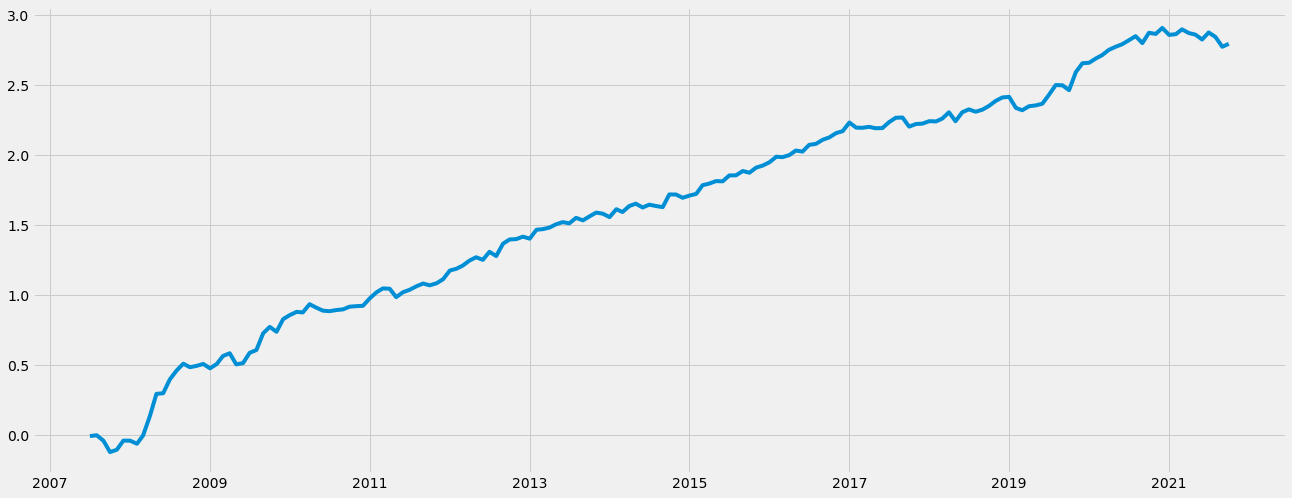

In [18]:
plt.figure(figsize=(20,8))
# plt.plot(weekly['date'], weekly['Cumulative Returns']*100);
# plt.plot(weekly['date'], weekly['ret']);
plt.plot(monthly['date'], monthly['Cumulative Returns']);
# plt.plot(monthly['date'], monthly['ret']);

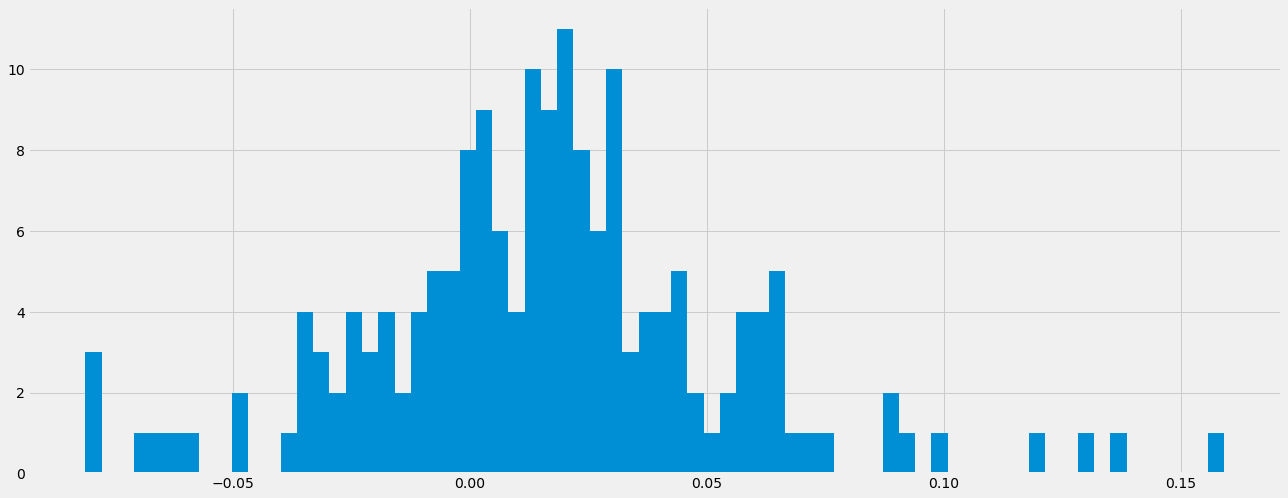

In [19]:
plt.figure(figsize=(20,8))
plt.hist(monthly['ret'], bins=70);

### to-do
- annualized return
- sharpe/sortino ration
- max drawdown
- period drawdown

[Annualized Return 1](https://12ft.io/proxy?q=https%3A%2F%2Fpython.plainenglish.io%2Fcalculating-annualized-expected-stock-returns-using-python-aaba430ca8a9)  
[get fred data](https://12ft.io/proxy?q=https%3A%2F%2Fmedium.com%2Fswlh%2Fpandas-datareader-federal-reserve-economic-data-fred-a360c5795013)  
[calculate sharpe ratio](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fcalculating-sharpe-ratio-with-python-755dcb346805)

In [47]:
rets = monthly.copy()
rets = rets[['date','ret']]
rets.set_index('date', inplace=True)
rets

annualized_return = (1 + rets['ret'].pct_change()).resample('Y').prod() - 1
annual_return = annualized_return.sum()
annual_std = annualized_return.std()
print(annualized_return)
print('annual return: ', annual_return, '\n', 'annual std: ', annual_std,)

date
2008-12-31 00:00:00-05:00   -13.755639
2009-12-31 00:00:00-05:00    -0.790208
2010-12-31 00:00:00-05:00     5.585614
2011-12-31 00:00:00-05:00    -0.970282
2012-12-31 00:00:00-05:00     9.789357
2013-12-31 00:00:00-05:00    -0.397377
2014-12-31 00:00:00-05:00    -1.461467
2015-12-31 00:00:00-05:00     1.882818
2016-12-31 00:00:00-05:00    -1.618872
2017-12-31 00:00:00-05:00    -0.032293
2018-12-31 00:00:00-05:00    -0.780585
2019-12-31 00:00:00-05:00     6.914735
2020-12-31 00:00:00-05:00     1.608359
2021-12-31 00:00:00-05:00    -0.320333
2022-12-31 00:00:00-05:00    -0.513859
Freq: A-DEC, Name: ret, dtype: float64
annual return:  5.1399678471661066 
 annual std:  5.181627754514318


In [39]:


source = 'https://fred.stlouisfed.org/data/TB3MS.txt'
interest_rate = float(pd.read_csv(source, sep=' ', skiprows=11).iloc[-1:]['Unnamed: 3'] / 100)

def sharpe(mean, interest, stdev):
    return (mean - interest) / stdev
    
sharpe(annual_return, interest_rate, annual_std)

0.9859195004340774

In [ ]:
# returns = monthly['ret']
# returns.index = monthly['date']
# empyrical.sharpe_ratio(returns)
# pf.create_simple_tear_sheet(returns, benchmark_rets=None)